# Interpolation


Parcels support a range of different interpolation methods for tracers, such as temperature. Here, we will show how these work, in an idealised example.

We first import the relevant modules


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

from parcels import FieldSet, JITParticle, ParticleSet

We create a small 2D grid where `P` is a tracer that we want to interpolate. In each grid cell, `P` has a random value between 0.1 and 1.1. We then set `P[1,1]` to `0`, which for Parcels specifies that this is a land cell


In [2]:
dims = [5, 4]
dx, dy = 1.0 / dims[0], 1.0 / dims[1]
dimensions = {
    "lat": np.linspace(0.0, 1.0, dims[0], dtype=np.float32),
    "lon": np.linspace(0.0, 1.0, dims[1], dtype=np.float32),
}
data = {
    "U": np.zeros(dims, dtype=np.float32),
    "V": np.zeros(dims, dtype=np.float32),
    "P": np.random.rand(dims[0], dims[1]) + 0.1,
}
data["P"][1, 1] = 0.0
fieldset = FieldSet.from_data(data, dimensions, mesh="flat")

We create a Particle class that can sample this field


In [3]:
SampleParticle = JITParticle.add_variable("p", dtype=np.float32)


def SampleP(particle, fieldset, time):
    particle.p = fieldset.P[time, particle.depth, particle.lat, particle.lon]

Now, we perform four different interpolation on `P`, which we can control by setting `fieldset.P.interp_method`. Note that this can always be done _after_ the `FieldSet` creation. We store the results of each interpolation method in an entry in the dictionary `pset`.


In [4]:
pset = {}
interp_methods = ["linear", "linear_invdist_land_tracer", "nearest", "cgrid_tracer"]
for p_interp in interp_methods:
    fieldset.P.interp_method = (
        p_interp  # setting the interpolation method for fieldset.P
    )

    xv, yv = np.meshgrid(np.linspace(0, 1, 8), np.linspace(0, 1, 8))
    pset[p_interp] = ParticleSet(
        fieldset, pclass=SampleParticle, lon=xv.flatten(), lat=yv.flatten()
    )
    pset[p_interp].execute(SampleP, endtime=1, dt=1)

100%|██████████| 1.0/1.0 [00:00<00:00, 639.38it/s]
100%|██████████| 1.0/1.0 [00:00<00:00, 663.66it/s]
100%|██████████| 1.0/1.0 [00:00<00:00, 832.70it/s]
100%|██████████| 1.0/1.0 [00:00<00:00, 532.47it/s]


And then we can show each of the four interpolation methods, by plotting the interpolated values on the `Particle` locations (circles) on top of the `Field` values (background colors)


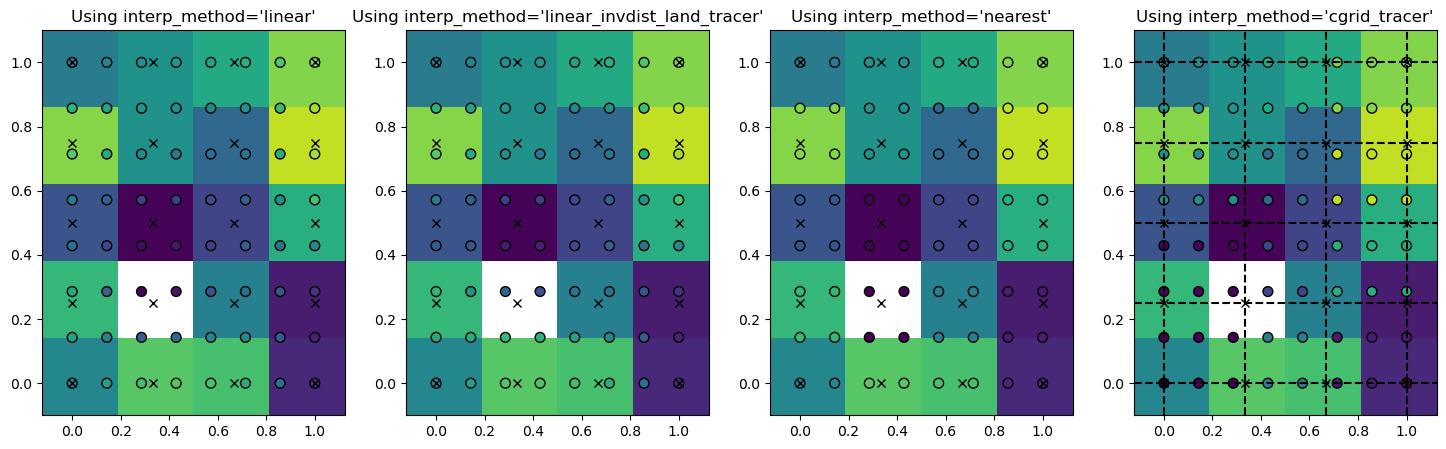

In [5]:
fig, ax = plt.subplots(1, 4, figsize=(18, 5))
for i, p in enumerate(pset.keys()):
    data = fieldset.P.data[0, :, :]
    data[1, 1] = np.nan
    x = np.linspace(-dx / 2, 1 + dx / 2, dims[0] + 1)
    y = np.linspace(-dy / 2, 1 + dy / 2, dims[1] + 1)
    if p == "cgrid_tracer":
        for lat in fieldset.P.grid.lat:
            ax[i].axhline(lat, color="k", linestyle="--")
        for lon in fieldset.P.grid.lon:
            ax[i].axvline(lon, color="k", linestyle="--")
    ax[i].pcolormesh(y, x, data, vmin=0.1, vmax=1.1)
    ax[i].scatter(
        pset[p].lon, pset[p].lat, c=pset[p].p, edgecolors="k", s=50, vmin=0.1, vmax=1.1
    )
    xp, yp = np.meshgrid(fieldset.P.lon, fieldset.P.lat)
    ax[i].plot(xp, yp, "kx")
    ax[i].set_title(f"Using interp_method='{p}'")
plt.show()

The white box is here the 'land' point where the tracer is set to zero and the crosses are the locations of the grid points. As you see, the interpolated value is always equal to the field value if the particle is exactly on the grid point (circles on crosses).

For `interp_method='nearest'`, the particle values are the same for all particles in a grid cell. They are also the same for `interp_method='cgrid_tracer'`, but the grid cells have then shifted. That is because in a C-grid, the tracer grid cell is on the top-right corner (black dashed lines in right-most panel).

For `interp_method='linear_invdist_land_tracer'`, we see that values are the same as `interp_method='linear'` for grid cells that don't border the land point. For grid cells that do border the land cell, the `linear_invdist_land_tracer` interpolation method gives higher values, as also shown in the difference plot below


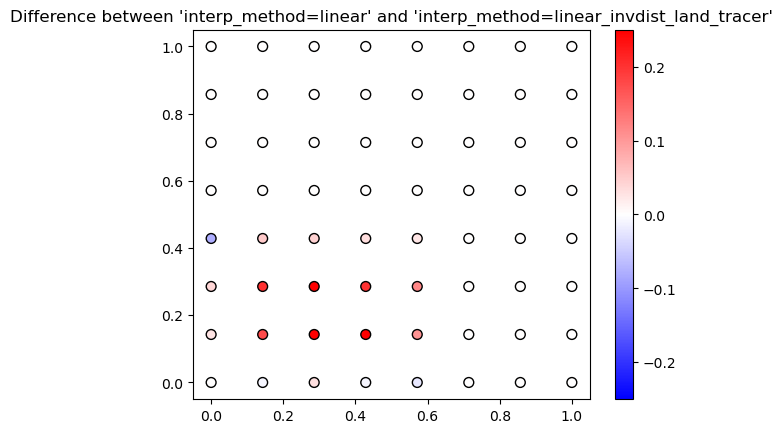

In [6]:
plt.scatter(
    pset["linear"].lon,
    pset["linear"].lat,
    c=pset["linear_invdist_land_tracer"].p - pset["linear"].p,
    edgecolors="k",
    s=50,
    cmap=cm.bwr,
    vmin=-0.25,
    vmax=0.25,
)
plt.colorbar()
plt.title(
    "Difference between 'interp_method=linear' "
    "and 'interp_method=linear_invdist_land_tracer'"
)
plt.show()

So in summary, Parcels has four different interpolation schemes for tracers:

1. `interp_method=linear`: compute linear interpolation
2. `interp_method=linear_invdist_land_tracer`: compute linear interpolation except near land (where field value is zero). In that case, inverse distance weighting interpolation is computed, weighting by squares of the distance.
3. `interp_method=nearest`: return nearest field value
4. `interp_method=cgrid_tracer`: return nearest field value supposing C cells
